ML-only CV: [0.91925466 0.86956522 0.88198758 0.91304348 0.89375   ] mean: 0.8955201863354038
Hybrid CV: [0.91304348 0.85714286 0.91304348 0.95031056 0.9       ] mean: 0.9067080745341615

--- ML-only Report ---
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       129
           1       0.82      0.82      0.82        73

    accuracy                           0.87       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.87      0.87      0.87       202


--- Hybrid Report ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       129
           1       0.81      0.84      0.82        73

    accuracy                           0.87       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.87      0.87      0.87       202



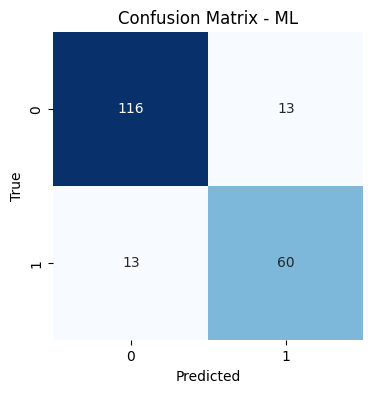

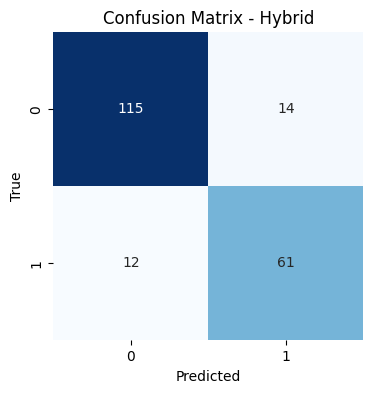

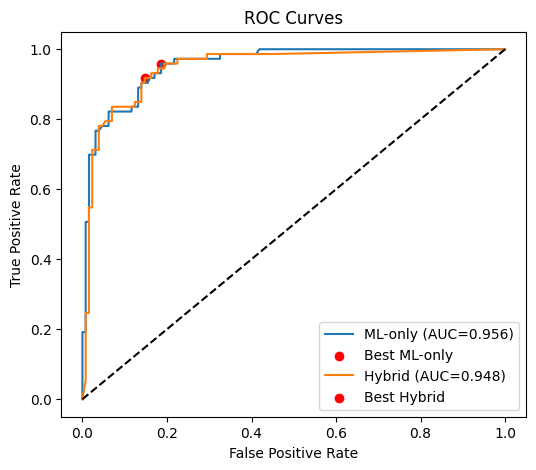


✅ Results saved: results.csv (with Phytochemical) & summary.csv
✅ Models saved: rf_ml_only.pkl & rf_hybrid.pkl


In [2]:
# rf_hybrid_vs_ml_with_features.py
"""
Random Forest vs Hybrid Random Forest (Rule + ML) comparison.
Now includes Phytochemical column tracking in results.csv.
"""

import re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# -------------------------
# Helper functions
# -------------------------
def sanitize_colname(s):
    return re.sub(r'[^A-Za-z0-9_]+', '', str(s).strip())

def clean_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).fillna("")
    s = s.str.replace(r'[\u2010-\u2015\u2212–—−]', '-', regex=True)
    s = s.str.replace(r'[,\~±]', '', regex=True)
    num = s.str.extract(r'(-?\d+\.?\d*(?:[eE][+-]?\d+)?)', expand=False)
    return pd.to_numeric(num, errors='coerce')

def make_onehot():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def get_probs_from_pipeline(pipe: Pipeline, X):
    clf = pipe.named_steps.get('classifier', pipe.steps[-1][1])
    if hasattr(clf, 'predict_proba'):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(clf, 'decision_function'):
        scores = pipe.decision_function(X)
        if np.ptp(scores) == 0:
            return np.zeros_like(scores, dtype=float)
        return (scores - scores.min()) / (scores.max() - scores.min())
    return np.zeros(len(X), dtype=float)

# -------------------------
# Load dataset
# -------------------------
df = pd.read_excel("Dataset.xlsx")
col_map = {c: sanitize_colname(c) for c in df.columns}
df.rename(columns=col_map, inplace=True)

# Detect target column
target_col = next((c for c in df.columns if "angiogen" in c.lower()), None)
if not target_col:
    raise KeyError("Target column not found (needs 'angiogen' in header).")

y = pd.to_numeric(df[target_col], errors="coerce").astype(int)
df_features = df.drop(columns=[target_col])

# Detect phytochemical/compound column
phytochemical_col = next(
    (c for c in df_features.columns if any(k in c.lower() for k in ["phytochem", "compound", "name"])),
    None
)
if phytochemical_col:
    phytochemical_series = df_features[phytochemical_col].copy()
    df_features = df_features.drop(columns=[phytochemical_col])
else:
    phytochemical_series = pd.Series(["Unknown"] * len(df_features))

# Detect docking/admet columns
docking_col, admet_col = None, None
for c in df_features.columns:
    cl = c.lower()
    if docking_col is None and ("dock" in cl or "score" in cl):
        docking_col = c
    if admet_col is None and "admet" in cl:
        admet_col = c

# Split numeric/categorical
numeric_cols, categorical_features = [], []
for c in df_features.columns:
    cleaned = clean_numeric_series(df_features[c])
    if cleaned.notna().mean() >= 0.3:
        df_features[c] = cleaned
        numeric_cols.append(c)
    elif df_features[c].dtype == object:
        categorical_features.append(c)

# Ensure docking/admet numeric
if docking_col:
    df_features[docking_col] = clean_numeric_series(df_features[docking_col])
    if docking_col not in numeric_cols:
        numeric_cols.append(docking_col)
if admet_col:
    df_features[admet_col] = pd.to_numeric(df_features[admet_col], errors="coerce")
    if admet_col not in numeric_cols:
        numeric_cols.append(admet_col)

X = df_features.copy()

# -------------------------
# Preprocessor
# -------------------------
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_onehot())
])
preprocessor = ColumnTransformer(
    [("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_features)],
    remainder="drop"
)

# -------------------------
# Rules
# -------------------------
def rule_based_decision_row(row):
    dock = float(row[docking_col]) if docking_col and pd.notnull(row.get(docking_col)) else None
    admet = int(row[admet_col]) if admet_col and pd.notnull(row.get(admet_col)) else None
    if admet == 0:
        return 0
    if dock is not None and admet == 1 and dock <= -9.0:
        return 1
    return None

def apply_hybrid_rules(Xdf, ml_preds, ml_probs):
    rd = Xdf.apply(rule_based_decision_row, axis=1)
    preds, probs = ml_preds.copy(), ml_probs.copy().astype(float)
    for i, decision in enumerate(rd):
        if decision in (0, 1):
            preds[i] = decision
            probs[i] = 1.0 if decision == 1 else 0.0
    return preds, probs

# -------------------------
# Train/test split (keep Phytochemical)
# -------------------------
X_train, X_test, y_train, y_test, phyto_train, phyto_test = train_test_split(
    X, y, phytochemical_series, test_size=0.2, stratify=y, random_state=42
)

# -------------------------
# Model training
# -------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42)
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

# Cross-validation
ml_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("ML-only CV:", ml_cv, "mean:", ml_cv.mean())

hybrid_cv = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr, val in cv.split(X_train, y_train):
    pipeline.fit(X_train.iloc[tr], y_train.iloc[tr])
    ml_preds = pipeline.predict(X_train.iloc[val])
    ml_probs = get_probs_from_pipeline(pipeline, X_train.iloc[val])
    hy_preds, _ = apply_hybrid_rules(X_train.iloc[val], ml_preds, ml_probs)
    hybrid_cv.append(accuracy_score(y_train.iloc[val], hy_preds))
hybrid_cv = np.array(hybrid_cv)
print("Hybrid CV:", hybrid_cv, "mean:", hybrid_cv.mean())

# -------------------------
# Evaluate test set
# -------------------------
pipeline.fit(X_train, y_train)
ml_preds_test = pipeline.predict(X_test)
ml_probs_test = get_probs_from_pipeline(pipeline, X_test)
hy_preds_test, hy_probs_test = apply_hybrid_rules(X_test, ml_preds_test, ml_probs_test)

print("\n--- ML-only Report ---")
print(classification_report(y_test, ml_preds_test))
print("\n--- Hybrid Report ---")
print(classification_report(y_test, hy_preds_test))

# -------------------------
# ROC & Confusion Matrix
# -------------------------
def plot_cm(y_true, preds, title):
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_test, ml_preds_test, "Confusion Matrix - ML")
plot_cm(y_test, hy_preds_test, "Confusion Matrix - Hybrid")

def plot_roc(y_true, probs, label):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    auc = roc_auc_score(y_true, probs)
    J = tpr - fpr
    ix = np.argmax(J)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.scatter(fpr[ix], tpr[ix], marker="o", color="red", label=f"Best {label}")
    return auc

plt.figure(figsize=(6,5))
auc_ml = plot_roc(y_test, ml_probs_test, "ML-only")
auc_hy = plot_roc(y_test, hy_probs_test, "Hybrid")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curves")
plt.show()

# -------------------------
# Save results (with Phytochemical)
# -------------------------
results_log = X_test.copy()
results_log.insert(0, "Phytochemical", phyto_test.values)  # ensure it's the first column
results_log["TrueLabel"] = y_test.values
results_log["ML_Pred"] = ml_preds_test
results_log["Hybrid_Pred"] = hy_preds_test
results_log["ML_Prob"] = ml_probs_test
results_log["Hybrid_Prob"] = hy_probs_test
results_log.to_csv("results.csv", index=False)

summary = pd.DataFrame([{
    "Model": "Random Forest",
    "ML_CV_mean": ml_cv.mean(),
    "Hybrid_CV_mean": hybrid_cv.mean(),
    "Test_Acc_ML": accuracy_score(y_test, ml_preds_test),
    "Test_Acc_Hybrid": accuracy_score(y_test, hy_preds_test),
    "ROC_AUC_ML": auc_ml,
    "ROC_AUC_Hybrid": auc_hy
}])
summary.to_csv("summary.csv", index=False)

print("\n✅ Results saved: results.csv (with Phytochemical) & summary.csv")

# -------------------------
# Save models
# -------------------------
ml_bundle = {
    "model": pipeline,
    "numeric_cols": numeric_cols,
    "categorical_features": categorical_features,
}
joblib.dump(ml_bundle, "rf_ml_only.pkl")

hy_bundle = {
    "model": pipeline,
    "docking_col": docking_col,
    "admet_col": admet_col,
    "numeric_cols": numeric_cols,
    "categorical_features": categorical_features,
}
joblib.dump(hy_bundle, "rf_hybrid.pkl")

print("✅ Models saved: rf_ml_only.pkl & rf_hybrid.pkl")


In [24]:
import joblib

# Load your original model bundles
rf_ml_only_bundle = joblib.load("rf_ml_only.pkl")
rf_hybrid_bundle = joblib.load("rf_hybrid.pkl")

# Function to clean a bundle
def clean_bundle(bundle, target_col='VEGFR-2'):
    # Remove Plant Source and target from features
    bundle['numeric_cols'] = [f for f in bundle['numeric_cols'] if f not in ['Plant Source', target_col]]
    bundle['categorical_features'] = [f for f in bundle['categorical_features'] if f not in ['Plant Source', target_col]]
    # Ensure target key exists for autofill
    bundle['target'] = target_col
    return bundle

# Clean both bundles
rf_ml_only_bundle_clean = clean_bundle(rf_ml_only_bundle)
rf_hybrid_bundle_clean = clean_bundle(rf_hybrid_bundle)

# Save cleaned bundles
joblib.dump(rf_ml_only_bundle_clean, "rf_ml_only_cleaned.pkl")
joblib.dump(rf_hybrid_bundle_clean, "rf_hybrid_cleaned.pkl")

print("Cleaned bundles saved successfully!")


Cleaned bundles saved successfully!


In [2]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import joblib
import os

# -------------------------------
# Load Models (from bundles)
# -------------------------------
ml_bundle = joblib.load("rf_ml_only_cleaned.pkl")
hybrid_bundle = joblib.load("rf_hybrid_cleaned.pkl")

ml_model = ml_bundle["model"]
hybrid_model = hybrid_bundle["model"]

# Feature setup (exclude PlantSource and Target)
all_features = [
    'Target', 'DockingScorekcalmol', 'ADMETHighlights1ADMETpasses0ADMETnotpasses',
    'MWgmol', 'LogP', 'TPSA', 'HBD', 'HBA',
    'RotB', 'AromaticRings', 'MR', 'PlantSource'
]
excluded = ['Target', 'PlantSource']
input_features = [f for f in all_features if f not in excluded]

# -------------------------------
# GUI Setup
# -------------------------------
root = tk.Tk()
root.title("Phytochemical Activity Prediction")
root.geometry("600x600")

entries = {}

# Create input fields for remaining features
for i, feature in enumerate(input_features):
    label = tk.Label(root, text=feature)
    label.grid(row=i, column=0, padx=10, pady=5, sticky="w")
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries[feature] = entry

# -------------------------------
# Prediction Function
# -------------------------------
def predict():
    try:
        # Collect inputs
        user_input = {}
        for feature in input_features:
            val = entries[feature].get()
            if val == "":
                messagebox.showerror("Error", f"Please enter value for {feature}")
                return
            try:
                user_input[feature] = float(val)
            except ValueError:
                user_input[feature] = val  # keep as string if not numeric

        # Autofill Target = -2
        user_input['Target'] = -2  

        # Autofill PlantSource = "Unknown"
        user_input['PlantSource'] = "Unknown"

        # Convert to DataFrame
        input_df = pd.DataFrame([user_input])

        # Run predictions
        ml_prob = ml_model.predict_proba(input_df)[0][1]
        hybrid_prob = hybrid_model.predict_proba(input_df)[0][1]

        # Show results
        result_text = f"ML Model Probability: {ml_prob:.4f}\nHybrid Model Probability: {hybrid_prob:.4f}"
        messagebox.showinfo("Prediction Result", result_text)

        # Save to CSV
        result_row = input_df.copy()
        result_row['ML_Prob'] = ml_prob
        result_row['Hybrid_Prob'] = hybrid_prob
        file_exists = os.path.isfile("GUIResults.csv")
        result_row.to_csv("GUIResults.csv", mode='a', header=not file_exists, index=False)

    except Exception as e:
        messagebox.showerror("Error", str(e))

# -------------------------------
# Buttons
# -------------------------------
predict_button = tk.Button(root, text="Predict", command=predict, bg="lightblue")
predict_button.grid(row=len(input_features)+1, column=0, columnspan=2, pady=20)

root.mainloop()
